In [6]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import json 
import os

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
import time

## PART I: Scraping all Finnish bands & create our DataFrame


In [4]:
my_user_agent = os.environ.get("Metal")
options=Options()
# options.add_argument("--headless")
options.add_argument(f"--user-agent={my_user_agent}")
driver = webdriver.Chrome(options=options)
url="https://www.metal-archives.com/lists/FI"
driver.get(url)
time.sleep(5)

tot_results=driver.find_element(By.XPATH,'//*[@id="bandListCountry_info"]')
tot=tot_results.text.split(" ")[5].replace(",","")
n_pages=round(int(tot)/500)

time.sleep(1)

band_list = []
for n in range(n_pages):
    band_names=driver.find_elements(By.XPATH,'//*[@id="bandListCountry"]/tbody/tr/td/a')
    band_genres=driver.find_elements(By.XPATH,'//*[@id="bandListCountry"]/tbody/tr/td[2]')
    band_location=driver.find_elements(By.XPATH,'//*[@id="bandListCountry"]/tbody/tr/td[3]')
    for b in range(len(band_names)):
        band_list.append({'Band':band_names[b].text,'Genre':band_genres[b].text,'Location':band_location[b].text})
    next_button = driver.find_element(By.XPATH,'//*[@id="bandListCountry_next"]')
    if not next_button.is_enabled():
        break
    next_button.click()
    
    time.sleep(2)

driver.quit()

print(band_list)

[{'Band': '...and Oceans', 'Genre': 'Symphonic Black Metal (early/later); Industrial/Electronic Metal (mid)', 'Location': 'Pietarsaari/Vaasa, Pohjanmaa'}, {'Band': '...Fallen', 'Genre': 'Gothic/Doom Metal/Ambient', 'Location': 'Hyvinkää, Uusimaa'}, {'Band': '.357 Soundsystem', 'Genre': "Death/Groove Metal, Death 'n' Roll", 'Location': 'Uusimaa'}, {'Band': '(Psychoparalysis)', 'Genre': 'Progressive Death Metal', 'Location': 'Vantaa, Uusimaa'}, {'Band': '0 X í S T', 'Genre': 'Blackened Doom Metal', 'Location': 'Riihimäki, Kanta-Häme'}, {'Band': '1990', 'Genre': 'Melodic/Blackened Death Metal', 'Location': 'Tampere, Pirkanmaa'}, {'Band': '2 Wolves', 'Genre': 'Gothic/Doom/Melodic Death Metal', 'Location': 'Lappeenranta, Etelä-Karjala'}, {'Band': '2nd Suicide', 'Genre': 'Melodic Death Metal', 'Location': 'Helsinki/Espoo, Uusimaa'}, {'Band': '300 Miles Between', 'Genre': 'Melodic Heavy Metal/Rock', 'Location': 'Vantaa, Uusimaa'}, {'Band': '359', 'Genre': 'Black Metal', 'Location': 'Turku, Va

In [10]:
df=pd.DataFrame(band_list)
df[['City','Region']]=df.Location.str.split(",",n=1,expand=True)

In [11]:
df.head(3)

Band                                              Genre  \
0     ...and Oceans  Symphonic Black Metal (early/later); Industria...   
1         ...Fallen                          Gothic/Doom Metal/Ambient   
2  .357 Soundsystem                 Death/Groove Metal, Death 'n' Roll   

                       Location               City      Region  
0  Pietarsaari/Vaasa, Pohjanmaa  Pietarsaari/Vaasa   Pohjanmaa  
1             Hyvinkää, Uusimaa           Hyvinkää     Uusimaa  
2                       Uusimaa            Uusimaa        None

In [12]:
df.to_excel("Finnish_bands2.xlsx")
df.to_csv("Finnish_bands2.csv")

<AxesSubplot: >

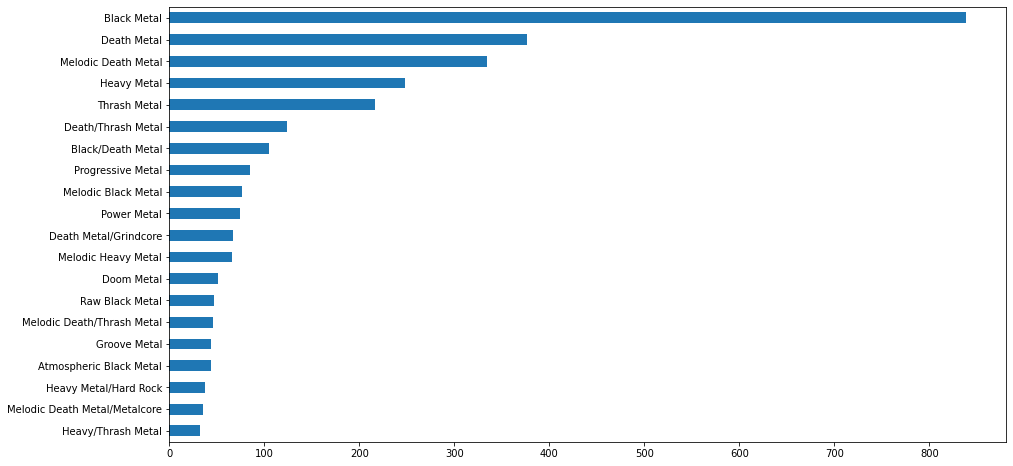

In [15]:
plt.subplots(figsize=(15,8))
fin_bands=pd.read_excel("Finnish_bands2.xlsx",index_col=0)
fin_bands['Genre'].value_counts().nlargest(20).sort_values(ascending=True).plot(kind='barh')

## Part II: Load and set up another Excel file for Finnish cities and a geojson file for finnish Regions

In [16]:
#Ricorda schema:
# 1) json.loads(input)   Converte l'input di tipo json-string in un output formato Python-dictionary
# 2) json.dumps(input)   Converte l'input di tipo Python-dictionary in un output (file json-string)
# 3) json.load(input)    Converte l'input (file json-dictionary/text) in un output formato Python-dictionary
# 4) json.dump(input)    Converte l'input di tipo Python-dictionary in un output (file json-dictionary/text)
with open("maakuntarajat-2018.json","r") as maakunta:
    maakuntarajat=json.load(maakunta)
kuma=gpd.GeoDataFrame.from_features(maakuntarajat)
kuma.head()

geometry    GML_ID  \
0  MULTIPOLYGON (((22.87094 63.83426, 22.89338 63...  27684688   
1  POLYGON ((26.68316 62.30773, 26.61059 62.29479...  27684667   
2  POLYGON ((24.17077 63.14800, 24.20318 63.15487...  27684674   
3  MULTIPOLYGON (((25.04140 65.05319, 25.05481 65...  27684695   
4  POLYGON ((22.96850 61.04325, 22.95994 61.05881...  27684618   

             NAMEFIN NATCODE                NAMESWE  
0    Keski-Pohjanmaa      16  Mellersta Ã–sterbotte  
1        Keski-Suomi      13      Mellersta Finland  
2   EtelÃ¤-Pohjanmaa      14    SÃ¶dra Ã–sterbotten  
3  Pohjois-Pohjanmaa      17     Norra Ã–sterbotten  
4          Pirkanmaa      06              Birkaland

In [17]:
kuma.NAMEFIN.unique()

array(['Keski-Pohjanmaa', 'Keski-Suomi', 'EtelÃ¤-Pohjanmaa',
       'Pohjois-Pohjanmaa', 'Pirkanmaa', 'Kanta-HÃ¤me', 'PÃ¤ijÃ¤t-HÃ¤me',
       'Uusimaa', 'Varsinais-Suomi', 'Ahvenanmaa', 'Pohjois-Savo',
       'EtelÃ¤-Savo', 'Lappi', 'Satakunta', 'Pohjanmaa', 'EtelÃ¤-Karjala',
       'Kymenlaakso', 'Pohjois-Karjala', 'Kainuu'], dtype=object)

In [18]:
w=pd.read_excel('worldcities.xlsx')
w.head()

city city_ascii      lat       lng    country iso2 iso3   admin_name  \
0      Tokyo      Tokyo  35.6897  139.6922      Japan   JP  JPN        Tōkyō   
1    Jakarta    Jakarta  -6.1750  106.8275  Indonesia   ID  IDN      Jakarta   
2      Delhi      Delhi  28.6100   77.2300      India   IN  IND        Delhi   
3  Guangzhou  Guangzhou  23.1300  113.2600      China   CN  CHN    Guangdong   
4     Mumbai     Mumbai  19.0761   72.8775      India   IN  IND  Mahārāshtra   

   capital  population          id  
0  primary  37732000.0  1392685764  
1  primary  33756000.0  1360771077  
2    admin  32226000.0  1356872604  
3    admin  26940000.0  1156237133  
4    admin  24973000.0  1356226629

In [19]:
finland=w[w['iso3']=='FIN']
finland.head()

city city_ascii      lat      lng  country iso2 iso3  \
602   Helsinki   Helsinki  60.1708  24.9375  Finland   FI  FIN   
2132   Tampere    Tampere  61.4981  23.7600  Finland   FI  FIN   
2362     Espoo      Espoo  60.2056  24.6556  Finland   FI  FIN   
2677     Turku      Turku  60.4500  22.2667  Finland   FI  FIN   
3082    Vantaa     Vantaa  60.2944  25.0403  Finland   FI  FIN   

           admin_name  capital  population          id  
602           Uusimaa  primary   1268296.0  1246177997  
2132        Pirkanmaa    admin    334112.0  1246964318  
2362          Uusimaa    minor    297132.0  1246357316  
2677  Varsinais-Suomi    admin    252468.0  1246456609  
3082          Uusimaa    minor    214605.0  1246957545

In [20]:
geo_finland=gpd.GeoDataFrame(finland,geometry=gpd.GeoSeries.from_xy(finland['lng'],finland['lat'],crs=4326))
geo_finland.rename(columns={'city':'City'},inplace=True)
geo_finland.head()

City city_ascii      lat      lng  country iso2 iso3  \
602   Helsinki   Helsinki  60.1708  24.9375  Finland   FI  FIN   
2132   Tampere    Tampere  61.4981  23.7600  Finland   FI  FIN   
2362     Espoo      Espoo  60.2056  24.6556  Finland   FI  FIN   
2677     Turku      Turku  60.4500  22.2667  Finland   FI  FIN   
3082    Vantaa     Vantaa  60.2944  25.0403  Finland   FI  FIN   

           admin_name  capital  population          id  \
602           Uusimaa  primary   1268296.0  1246177997   
2132        Pirkanmaa    admin    334112.0  1246964318   
2362          Uusimaa    minor    297132.0  1246357316   
2677  Varsinais-Suomi    admin    252468.0  1246456609   
3082          Uusimaa    minor    214605.0  1246957545   

                       geometry  
602   POINT (24.93750 60.17080)  
2132  POINT (23.76000 61.49810)  
2362  POINT (24.65560 60.20560)  
2677  POINT (22.26670 60.45000)  
3082  POINT (25.04030 60.29440)

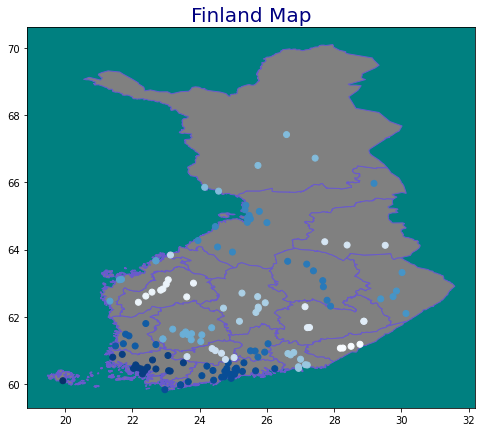

In [21]:
a=kuma.plot(color='grey',figsize=(25,7),edgecolor='slateblue')
geo_finland.plot('admin_name',ax=a,aspect='equal',cmap='Blues')
a.set_facecolor('teal')
plt.title('Finland Map',color='navy',size=20)
plt.show()

#### Why regions (admin_name) are colored as points and not area? The reason is we previously set geometry as 'Point' coordinates

In [22]:
m=kuma.explore()
geo_finland.explore(column='City',m=m,cmap='plasma',marker_type='circle',tooltip=True,
                    marker_kwds={'radius':0.1,'fill':True},legend=True)

In [23]:
fin_bands.isnull().sum()

Band          0
Genre         0
Location    755
City        755
Region      847
dtype: int64

In [24]:
fin_bands.dropna(inplace=True)
len(fin_bands)

4449

In [25]:
fin_bands[['Right','Wrong']]=fin_bands['City'].str.split("/",n=1,expand=True)
fin_bands.drop(columns=['City','Wrong'],inplace=True)
fin_bands.rename(columns={'Right':'City'},inplace=True)
fin_total=gpd.GeoDataFrame(fin_bands.merge(geo_finland,on='City'))
fin_total.head()

Band                          Genre           Location    Region  \
0    ...Fallen      Gothic/Doom Metal/Ambient  Hyvinkää, Uusimaa   Uusimaa   
1   Atheme One                    Power Metal  Hyvinkää, Uusimaa   Uusimaa   
2    Aurotanic                    Black Metal  Hyvinkää, Uusimaa   Uusimaa   
3  Autua Sagas  Melodic Death Metal/Metalcore  Hyvinkää, Uusimaa   Uusimaa   
4      Azaghal                    Black Metal  Hyvinkää, Uusimaa   Uusimaa   

       City city_ascii      lat    lng  country iso2 iso3 admin_name capital  \
0  Hyvinkää   Hyvinkaa  60.6333  24.85  Finland   FI  FIN    Uusimaa   minor   
1  Hyvinkää   Hyvinkaa  60.6333  24.85  Finland   FI  FIN    Uusimaa   minor   
2  Hyvinkää   Hyvinkaa  60.6333  24.85  Finland   FI  FIN    Uusimaa   minor   
3  Hyvinkää   Hyvinkaa  60.6333  24.85  Finland   FI  FIN    Uusimaa   minor   
4  Hyvinkää   Hyvinkaa  60.6333  24.85  Finland   FI  FIN    Uusimaa   minor   

   population          id                   geometry  
0     46739.0  1246789945  POINT (24.85000 60.63330)  
1     46739.0  1246789945  POINT (24.85000 60.63330)  
2     46739.0  1246789945  POINT (24.85000 60.63330)  
3     46739.0  1246789945  POINT (24.85000 60.63330)  
4     46739.0  1246789945  POINT (24.85000 60.63330)

In [26]:
fin_total.Region.unique()

array([' Uusimaa', ' Uusimaa/Jyväskylä, Keski-Suomi',
       ' Uusimaa (early); Hudiksvall, Sweden (mid); Uusimaa, Finland (later)',
       ' Kanta-Häme', ' Kanta-Häme/Tampere, Pirkanmaa', ' Pirkanmaa',
       ' Pirkanmaa / Helsinki, Uusimaa',
       ' Pirkanmaa (early); Helsinki, Uusimaa (later)',
       ' Pirkanmaa/Helsinki, Uusimaa', ' Pirkanmaa/Espoo, Uusimaa',
       ' Pirkanmaa / Jalasjärvi, Etelä-Pohjanmaa',
       ' Pirkanmaa / Oulu, Pohjois-Pohjanmaa',
       ' Pirkanmaa/Oulu, Pohjois-Pohjanmaa',
       ' Pirkanmaa/Turku, Varsinais-Suomi',
       ' Pirkanmaa (early); Vihti, Uusimaa (later)',
       ' Pirkanmaa/Vantaa, Uusimaa',
       ' Pirkanmaa / Hämeenlinna, Kanta-Häme (early); Helsinki, Uusimaa (later)',
       ' Pirkanmaa/Seinäjoki, Etelä-Pohjanmaa',
       ' Pirkanmaa/Jyväskylä, Keski-Suomi',
       ' Pirkanmaa/Mikkeli, Etelä-Savo',
       ' Pirkanmaa/Varkaus, Pohjois-Savo', ' Etelä-Karjala',
       ' Etelä-Karjala/Jyväskylä, Keski-Suomi/Kitee, Pohjois-Karjala',
       '

In [27]:
import re
patterns_dict = {
    r"\bUusimaa\b.*\bearly\b": "Uusimaa",
    r"\bUusimaa\b.*\blater\b": "Uusimaa",
    r"\b.*Uusimaa\b": "Uusimaa",
    r"\b.*Kanta-Häme\b":"Kanta-Häme",
    r"\b.*Etelä-Karjala\b":"Etelä-Karjala",
    r"\bEtelä-Pohjanmaa\b.*\bearly\b":"Etelä-Pohjanmaa",
    r"\b.*Etelä-Pohjanma.*\b.*":"Etelä-Pohjanmaa",
    r"\b.*Päijät-Häme\b.*":"Päijät-Häme",
    r"\b.*Pohjois-.*Pohjanmaa\b.*":"Pohjois-Pohjanmaa",
    r"\b.*Pohjois-Karjala\b.*":"Pohjois-Pohjanmaa",
    r"\b.*Pirkanmaa\b.*":"Pirkanmaa",
    r"\b.*Satakunta\b.*":"Satakunta",
    r"\b.*Etelä-Savo\b.*":"Etelä-Savo",
    r"\b.*Varsinais-Suomi\b.*":"Varsinais-Suomi",
    r"\b.*Keski-Suom.*\b.*":"Keski-Suomi",
    r"\b.*Kainuu\b.*":"Kainuu",
    r"\b.*Kymenlaakso\b.*":"Kymenlaakso",
    r"\b.*Lappi\b.*":"Lappi",
    r"\b.*Pohjois-Savo\b.*":"Pohjois-Savo",
    r"\b.*Pohjanmaa\b.*":"Pohjanmaa",
    r"\b.*Vakka-Suomi\b.*":"Varsinais-Suomi",
    r"\b.*Central Finland\b.*":"Keski-Suomi",
    r"\b.*Finland\b.*":"Uusimaa",
    r"\b.*Northern Savonia\b.*":"Pohjois-Karjala",
    r"\b.*Varkaus\b.*":"Pohjois-Karjala"
}
def standardize_region(region):
    for pattern, name in patterns_dict.items():
        if re.search(pattern, region):
            return name
    return region
fin_total["Region"] = fin_total["Region"].apply(standardize_region)

fin_total['Region']=fin_total['Region'].apply(lambda x: x.split("/")[0]).apply(lambda x: x.split("(")[0])
fin_total.Region.unique()

array(['Uusimaa', 'Kanta-Häme', 'Pirkanmaa', 'Etelä-Pohjanmaa',
       'Pohjois-Pohjanmaa', 'Etelä-Karjala', ' Laajavuorenkuja',
       'Varsinais-Suomi', 'Satakunta', 'Päijät-Häme', 'Etelä-Savo',
       'Keski-Suomi', 'Kainuu', 'Kymenlaakso', 'Lappi', 'Pohjois-Savo',
       'Pohjanmaa', 'Pohjois-Karjala', ' Järvenpää'], dtype=object)

In [28]:
print(sorted(fin_total.Region.unique()),len(fin_total.Region.unique()),sep="\n\n")

[' Järvenpää', ' Laajavuorenkuja', 'Etelä-Karjala', 'Etelä-Pohjanmaa', 'Etelä-Savo', 'Kainuu', 'Kanta-Häme', 'Keski-Suomi', 'Kymenlaakso', 'Lappi', 'Pirkanmaa', 'Pohjanmaa', 'Pohjois-Karjala', 'Pohjois-Pohjanmaa', 'Pohjois-Savo', 'Päijät-Häme', 'Satakunta', 'Uusimaa', 'Varsinais-Suomi']

19


In [29]:
print(len(fin_bands),len(fin_total),sep='\n')

4449
4032


# Let's start by a general picture: all cities with a band

In [30]:
a=fin_total.explore(tiles='CartoDB dark_matter',legend=False)
fin_total.explore(column='Band',m=a,tooltip=['City','Band'],legend=False,color='Band',cmap='winter')

## Next goal: watching how many bands by city

In [31]:
fin_sub=fin_total[['Band','Genre','Region','City','population','geometry']]
# plt.subplots(figsize=(15,5))
fin_for_plot=fin_sub.groupby(['Region','City'])['Band'].nunique().sort_values(ascending=True).nlargest(10).reset_index()


fig = go.Figure(px.bar(fin_for_plot,x='Band',y='City',color='Region',color_discrete_sequence=px.colors.sequential.Plasma,
                       title='Number of Bands by City',text_auto='.2s',orientation='h'))
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'},paper_bgcolor='LightSteelBlue')
fig.update_layout(
    font_family="Ayuthaya ",
    font_color="blue",
    font_size=15,
    title_font_family="Times New Roman",
    title_font_color="navy",
    title_x=0.5,
    legend_title_font_color="purple"
)
fig.update_xaxes(title_font_family="Arial",title_font_size=18,title_font_color='purple')
fig.update_yaxes(title_font_family="Arial",title_font_size=18,title_font_color='purple')

In [32]:
# kuma.rename(columns={'geometry':'geometry_region','NAMEFIN':'City'},inplace=True)
kuma.rename(columns={'geometry':'geometry_region','NAMEFIN':'Region'},inplace=True)
# ku=ku[['geometry_region','City']]
kuma=kuma[['geometry_region','Region']]
fin_total.drop(columns=['Location','lat','lng','iso2','admin_name','id','capital'],inplace=True)

In [33]:
# final=gpd.GeoDataFrame(fin_total.merge(kuma,on='City'))
final=gpd.GeoDataFrame(fin_total.merge(kuma,on='Region'))
final.head(2)

Band                      Genre   Region      City city_ascii  \
0   ...Fallen  Gothic/Doom Metal/Ambient  Uusimaa  Hyvinkää   Hyvinkaa   
1  Atheme One                Power Metal  Uusimaa  Hyvinkää   Hyvinkaa   

   country iso3  population                   geometry  \
0  Finland  FIN     46739.0  POINT (24.85000 60.63330)   
1  Finland  FIN     46739.0  POINT (24.85000 60.63330)   

                                     geometry_region  
0  MULTIPOLYGON (((23.41350 59.88761, 23.43453 59...  
1  MULTIPOLYGON (((23.41350 59.88761, 23.43453 59...

In [34]:
count=final.groupby(['Region'],as_index=False)[['Band','geometry','geometry_region']].agg({'Band':'nunique',
                                'geometry':'first','geometry_region':'first'}).sort_values(by='Band',ascending=False)

count=count.drop(columns='geometry')
count.rename(columns={'geometry_region':'geometry'},inplace=True)
count.head()

Region  Band                                           geometry
10            Uusimaa  1288  MULTIPOLYGON (((23.41350 59.88761, 23.43453 59...
7   Pohjois-Pohjanmaa   508  MULTIPOLYGON (((25.04140 65.05319, 25.05481 65...
4           Pirkanmaa   415  POLYGON ((22.96850 61.04325, 22.95994 61.05881...
11    Varsinais-Suomi   314  MULTIPOLYGON (((22.50559 59.86893, 22.41120 59...
1         Keski-Suomi   272  POLYGON ((26.68316 62.30773, 26.61059 62.29479...

In [35]:
count_geo=gpd.GeoDataFrame(count)
a=kuma['geometry_region'].explore()#now we use square brackets as we changed 'geometry' name 
count_geo.head(25).explore(column='Band',m=a,cmap='plasma')
# Important: we just selected top 15 values only 'cause 'tail' function earlier showed us
# a series of 'weird'/confusing data including word Uusima

#Alternative:
# prova=gpd.GeoDataFrame(ku.merge(count.head(20),on='geometry'))
# prova.explore(column='Band')

<AxesSubplot: >

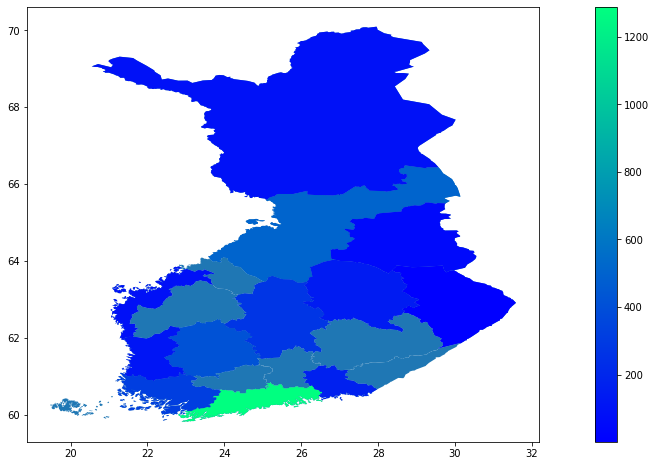

In [36]:
a=kuma['geometry_region'].plot(figsize=(20,8))
count_geo.head(15).plot(column='Band',ax=a,aspect='equal',cmap='winter',legend=True)

## ....and now in Plotly

In [37]:
# finland2=gpd.GeoDataFrame(count_geo)
count_geo.to_file('finland.geojson',driver='GeoJSON')
with open('finland.geojson','r') as fin:
    fi=json.load(fin)

In [38]:
fig=px.choropleth(count_geo,geojson=fi,locations='Region',featureidkey='properties.Region', scope='europe',
              color='Band', width=800, height=400)
fig.update_layout(title='Finnish Metal bands by Regions',title_x=0,title_y=0.5,title_font_family="Times New Roman"
                  ,title_font_color='navy',title_font_size=20)
fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0},paper_bgcolor='lightgrey')
fig.update_geos(fitbounds='locations', visible=False)